In [6]:
import lightgbm as lgb
import optuna.visualization as vis

import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [11]:
import seaborn as sns

In [12]:
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)

Seaborn version: 0.13.2
Matplotlib version: 3.10.3


In [1]:
filepath = '../../split_year_data'

### Encoding Countries

In [6]:
merged = pd.DataFrame(pd.read_pickle('../../raw_merged_data_v2_withinyears'))
missing_dropped = merged.dropna(axis=1, how='all', ignore_index=True)
rdrop = missing_dropped.dropna(axis=0, how='all', ignore_index=True)
ydrop = missing_dropped.dropna(subset=['Maternal mortality ratio (national estimate, per 100,000 live births)'])

In [7]:
ydrop = ydrop[ydrop['date'] < 2019]

In [ ]:
countries = ydrop['setting'].unique()
countries_dict = {}
count = 0
for c in countries:
    countries_dict[c] = count
    count += 1


In [33]:
len(countries_dict)

173

In [7]:
import pickle 

with open('../../split_year_data/countries_dict.pkl', 'wb') as f:
    pickle.dump(countries_dict, f)

NameError: name 'countries_dict' is not defined

### Loading Datasets

In [8]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [9]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

In [10]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

### Objective Function

In [3]:
def objective(trial, x_train, y_train, x_val, y_val):

    n_trees = trial.suggest_int("number_trees", 10, 300)

    max_depth = trial.suggest_int("max_tree_depth", 3, 25)

    boosting_type = trial.suggest_categorical("boosting_type", ['gbdt', 'dart'])
    
    bagging_fraction = trial.suggest_float("bagging_fraction", 0.1, 1.0)
    bagging_freq = trial.suggest_int("bagging_freq", 0, 10)

    learning_rate = trial.suggest_float("learning_rate", 0, 1)
    l1_norm = trial.suggest_float("l1_norm", 0, 0.001)
    l2_norm = trial.suggest_float("l2_norm", 0, 0.001)

    lgbm_model = lgb.LGBMRegressor(random_state=42, verbosity = -1, n_estimators=n_trees, boosting=boosting_type, max_depth=max_depth, learning_rate=learning_rate, reg_alpha=l1_norm, reg_lambda=l2_norm, bagging_fraction=bagging_fraction, bagging_freq=bagging_freq)
    trained_model = lgbm_model.fit(x_train, y_train)
    y_pred = trained_model.predict(x_val)
    val_loss = mean_squared_error(y_pred, y_val)

    return val_loss  # Optuna minimizes this

### Model Iteration

#### Code Design

#### Code Implementation

In [4]:
output_dir = '../../split_year_models/lightgbm'

In [11]:
#because lightgbm cannot handle the comma
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold in range(0, 5):
    val_input_data = validation[fold][0].copy()
    val_input_data['setting'] = val_input_data['setting'].astype("category")
    val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    val_label = validation[fold][1].copy()
    val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    for thresh_idx, thresh in enumerate(['85', '95', '1']):
        if thresh_idx != 2:
            continue
        train_input_data = train[fold][thresh_idx * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh_idx * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        #Create a study object and optimize the objective function.
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_input_data, val_label), n_trials=300)
        best_model = lgb.LGBMRegressor(**study.best_params)
        best_model.fit(train_input_data, train_label)
        
        #save best model 
        joblib.dump(best_model, output_dir + '/best_model_' + str(fold) + '_' + thresh +  '.pkl')
        joblib.dump(study.best_params, f"{output_dir}/best_params_{fold}_{thresh}.pkl")

        # Save study for later visualization
        joblib.dump(study, f"{output_dir}/optuna_study_{fold}_{thresh}.pkl")

        summary = {
            "dataset": str(fold) + '_' + thresh,
            "fold" : fold,
            "threshold": thresh,
            "model": 'lightgbm',
            "best_params": study.best_params,
            "best_optuna_loss": study.best_value
        }

        with open(f"{output_dir}/results_{fold}_{thresh}.json", "w") as f:
            json.dump(summary, f, indent=2)

[I 2025-08-10 11:33:05,045] A new study created in memory with name: no-name-2462c86a-c6d1-4233-b001-3ce22004d891
[I 2025-08-10 11:33:09,301] Trial 0 finished with value: 5431.208281202132 and parameters: {'number_trees': 209, 'max_tree_depth': 21, 'boosting_type': 'gbdt', 'bagging_fraction': 0.8663190427752395, 'bagging_freq': 1, 'learning_rate': 0.8333756743872784, 'l1_norm': 0.0009245009619527431, 'l2_norm': 0.0005253860358575482}. Best is trial 0 with value: 5431.208281202132.
[I 2025-08-10 11:33:14,436] Trial 1 finished with value: 4916.583999642042 and parameters: {'number_trees': 234, 'max_tree_depth': 19, 'boosting_type': 'dart', 'bagging_fraction': 0.6088178691192612, 'bagging_freq': 4, 'learning_rate': 0.7937394571670818, 'l1_norm': 0.0007418146059150025, 'l2_norm': 0.00010717453955140465}. Best is trial 1 with value: 4916.583999642042.
[I 2025-08-10 11:33:16,035] Trial 2 finished with value: 6953.250406540001 and parameters: {'number_trees': 164, 'max_tree_depth': 10, 'boost

Now looking at instances where data has been dropped due to the missing data thresholds

In [12]:
#because lightgbm cannot handle the comma
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold in range(0, 5):
    val_input_data = validation[fold][0].copy()
    val_input_data['setting'] = val_input_data['setting'].astype("category")
    val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    val_label = validation[fold][1].copy()
    val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    for thresh_idx, thresh in enumerate(['85', '95', '1']):
        if thresh_idx == 2:
            continue

        train_input_data = train[fold][thresh_idx * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh_idx * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = val_input_data.columns.intersection(train_input_data.columns)
        val_relevant_input = val_input_data[columns_needed]

        #Create a study object and optimize the objective function.
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_relevant_input, val_label), n_trials=300)
        best_model = lgb.LGBMRegressor(**study.best_params)
        best_model.fit(train_input_data, train_label)
        
        #save best model 
        joblib.dump(best_model, output_dir + '/best_model_' + str(fold) + '_' + thresh +  '.pkl')
        joblib.dump(study.best_params, f"{output_dir}/best_params_{fold}_{thresh}.pkl")

        # Save study for later visualization
        joblib.dump(study, f"{output_dir}/optuna_study_{fold}_{thresh}.pkl")

        summary = {
            "dataset": str(fold) + '_' + thresh,
            "fold" : fold,
            "threshold": thresh,
            "model": 'lightgbm',
            "best_params": study.best_params,
            "best_optuna_loss": study.best_value
        }

        with open(f"{output_dir}/results_{fold}_{thresh}.json", "w") as f:
            json.dump(summary, f, indent=2)

[I 2025-08-10 12:39:08,308] A new study created in memory with name: no-name-cf84be1f-2637-4553-abe0-2d3c67373145


[I 2025-08-10 12:39:13,700] Trial 0 finished with value: 6699.156928733429 and parameters: {'number_trees': 300, 'max_tree_depth': 7, 'boosting_type': 'dart', 'bagging_fraction': 0.9637296744429557, 'bagging_freq': 4, 'learning_rate': 0.276112578271568, 'l1_norm': 0.00023578953318981267, 'l2_norm': 0.0009001494161789293}. Best is trial 0 with value: 6699.156928733429.
[I 2025-08-10 12:39:15,709] Trial 1 finished with value: 9856.802301070858 and parameters: {'number_trees': 89, 'max_tree_depth': 22, 'boosting_type': 'dart', 'bagging_fraction': 0.5137411506777502, 'bagging_freq': 3, 'learning_rate': 0.5827537785547502, 'l1_norm': 0.0008378417709755411, 'l2_norm': 1.0857644660112853e-05}. Best is trial 0 with value: 6699.156928733429.
[I 2025-08-10 12:39:18,447] Trial 2 finished with value: 8345.876620072046 and parameters: {'number_trees': 101, 'max_tree_depth': 17, 'boosting_type': 'gbdt', 'bagging_fraction': 0.3297951526160163, 'bagging_freq': 0, 'learning_rate': 0.6011398990802617, '

### Loading Models

In [25]:
output_dir = '../../split_year_models/lightgbm'

#### Test values for all models

In [26]:
# setting up the dataframe to hold test results
index = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)
test_stats = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

test_stats

MAPE  MAE  MSE RMSE   R2
Missing Data Threshold Fold                         
Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
None                   1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN

In [27]:
test_data_y.iloc[0] + 5

Maternal mortality ratio (national estimate, per 100,000 live births)    456.0
Name: 0, dtype: float64

In [28]:
best_parameters = {'Threshold 85%' : [], 'Threshold 95%' : [], 'None' : []}

In [29]:
test_data_x['setting'] = test_data_x['setting'].astype("category")
testing_x = test_data_x.copy()
testing_x.columns = testing_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/best_params_{fold}_{name}.pkl")
        best_parameters[thresh_name].append(best_params)
        best_model = joblib.load(f"{output_dir}/best_params_{fold}_{name}.pkl")

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = testing_x.columns.intersection(train_input_data.columns)
        to_test = testing_x[columns_needed].copy()

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(prediction, test_data_y)
        mae = mean_absolute_error(prediction, test_data_y)
        rmse = np.sqrt(mse)
        r2 = r2_score(prediction, test_data_y)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        mape = mape/num_predictions
        #mape = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), 'MSE'] = mse
        test_stats.loc[(thresh_name, fold_num), 'MAE'] = mae
        test_stats.loc[(thresh_name, fold_num), 'RMSE'] = rmse
        test_stats.loc[(thresh_name, fold_num), 'R2'] = r2
        test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
        

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_6839/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_6839/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_6839/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beh

KeyboardInterrupt: 

In [ ]:
test_stats

MAPE        MAE          MSE       RMSE  \
Missing Data Threshold Fold                                                
Threshold 85%          1     0.632721  34.205167  7839.655299  88.541828   
                       2     0.475964  31.331315  6907.783992   83.11308   
                       3     0.569557  35.405582   8448.65437  91.916562   
                       4      0.55892  35.081261  7757.821859  88.078498   
                       5     0.620653  33.748915  6525.118235  80.778204   
Threshold 95%          1     0.433841  29.563303   6932.65629  83.262574   
                       2     0.393833  26.891395   6046.54966  77.759563   
                       3     0.492076  29.662452  7916.786365  88.976325   
                       4     0.426257  28.017048   5450.35357   73.82651   
                       5     0.483688  26.434454  4020.521182   63.40758   
None                   1     0.541524  33.423908  5182.814024  71.991764   
                       2     0.386906  26.252009  5740.260429  75.764506   
                       3     0.705976  45.736768  8817.900205  93.903675   
                       4      0.39931  28.436149  6581.446064  81.126112   
                       5     0.442781  27.857194  4859.720582  69.711696   

                                   R2  
Missing Data Threshold Fold            
Threshold 85%          1     0.545489  
                       2     0.600196  
                       3     0.585594  
                       4     0.537712  
                       5     0.764171  
Threshold 95%          1     0.667872  
                       2     0.667768  
                       3     0.660139  
                       4     0.721142  
                       5     0.841763  
None                   1     0.787078  
                       2     0.751439  
                       3     0.652151  
                       4     0.620062  
                       5     0.781669

In [ ]:
mean_summary = test_stats.groupby(level='Missing Data Threshold').mean()
mean_summary = mean_summary.astype('float')
mean_summary = mean_summary.round(2)
std_summary = test_stats.groupby(level='Missing Data Threshold').std()
std_summary = std_summary.astype('float')
std_summary = std_summary.round(2)

In [ ]:
# setting up the dataframe to hold summary of cross-fold validation results
summary_index = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)

summary_stats = pd.DataFrame(index=['Threshold 85%', 'Threshold 95%', 'None'], columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

for thresh_idx, thresh in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
    for metric_idx, metric in enumerate(['MAPE', 'MAE', 'MSE', 'RMSE', 'R2']):
        summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])

summary_stats

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_6839/2971279602.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_6839/2971279602.py:13: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])


,MAPE,MAE,MSE,RMSE,R2
Threshold 85%,0.5 +- 0.13,32.34 +- 7.95,6236.43 +- 1583.88,78.5 +- 9.63,0.72 +- 0.08
Threshold 95%,0.57 +- 0.06,33.95 +- 1.61,7495.81 +- 771.82,86.49 +- 4.48,0.61 +- 0.09
None,0.45 +- 0.04,28.11 +- 1.49,6073.37 +- 1478.14,77.45 +- 9.71,0.71 +- 0.08


#### Best Parameters

#### Visualisation

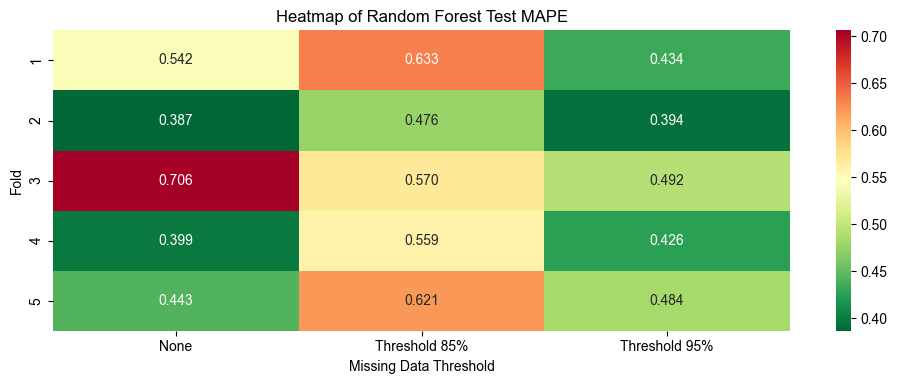

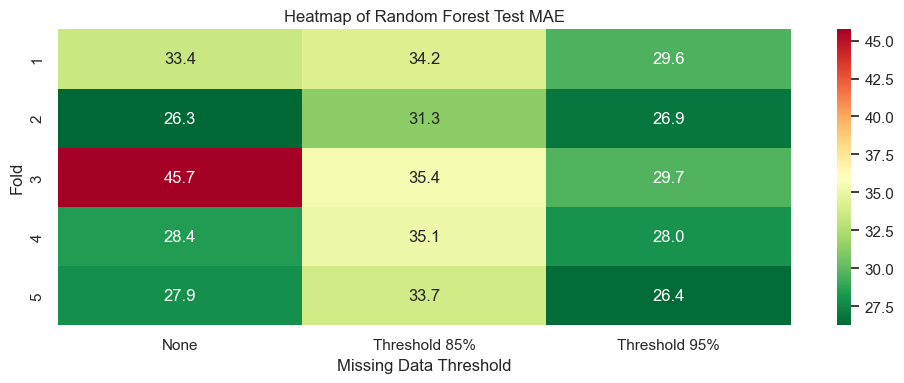

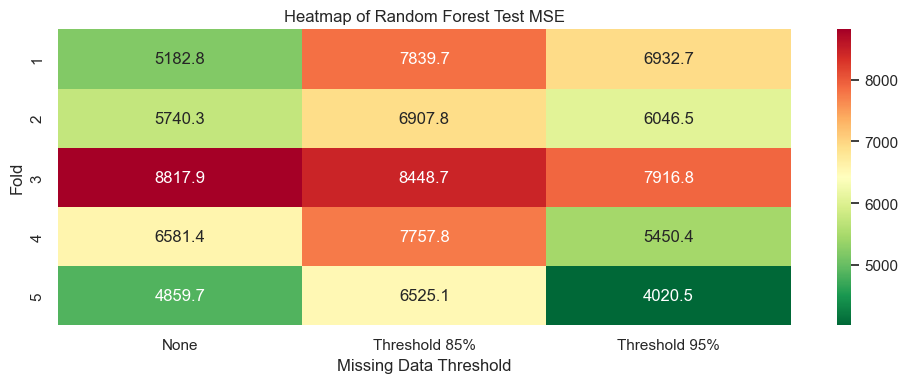

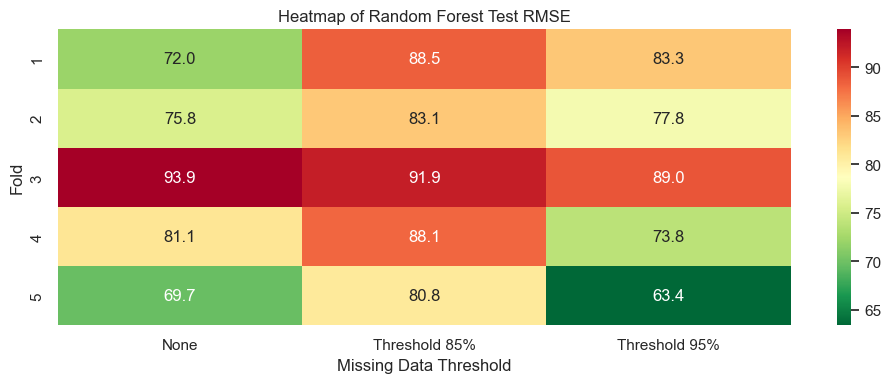

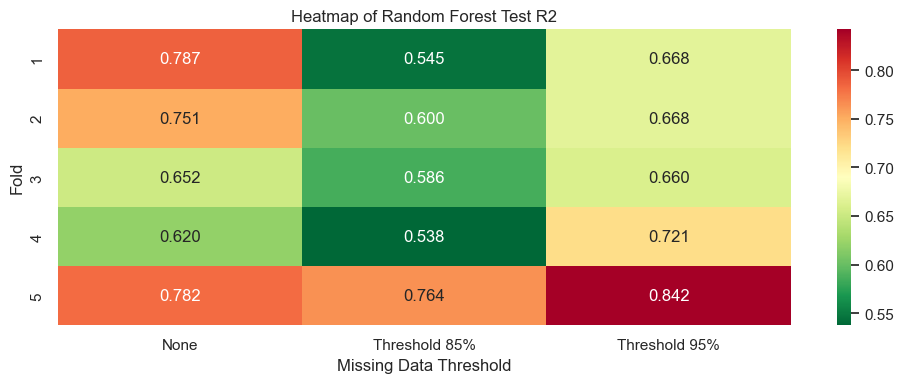

In [ ]:
import seaborn as sns

data = test_stats.astype(float)

for metric in data.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of Random Forest Test " + metric)
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

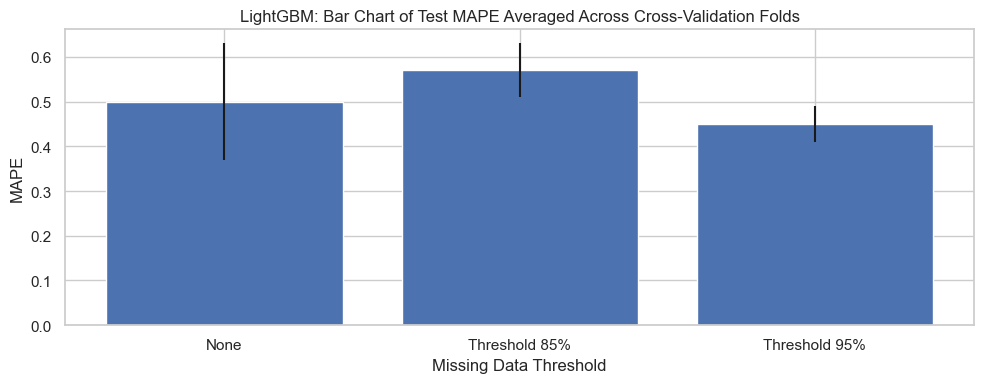

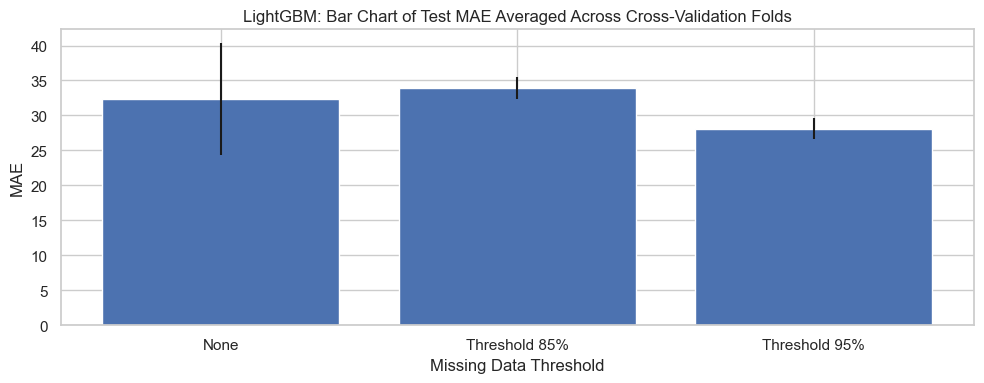

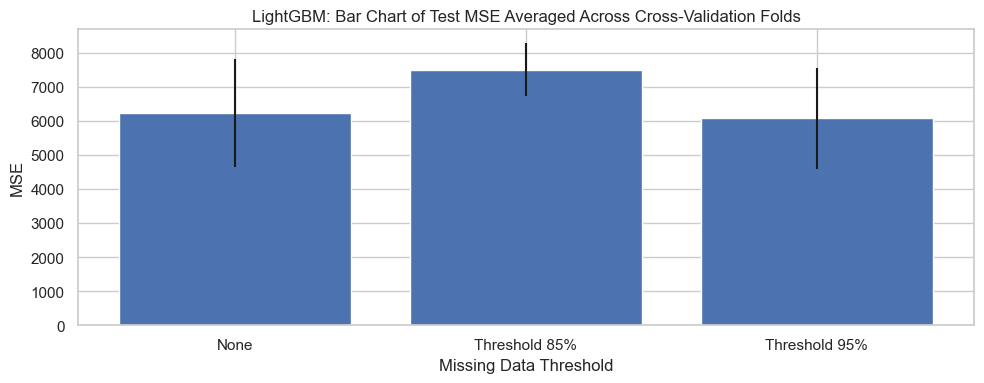

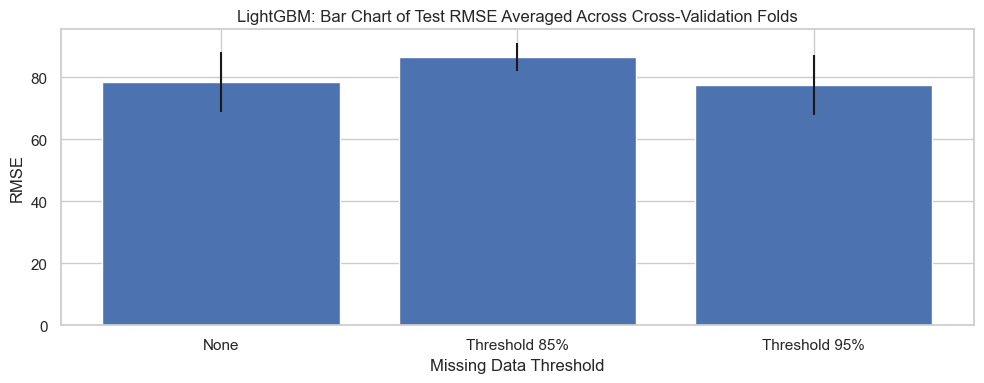

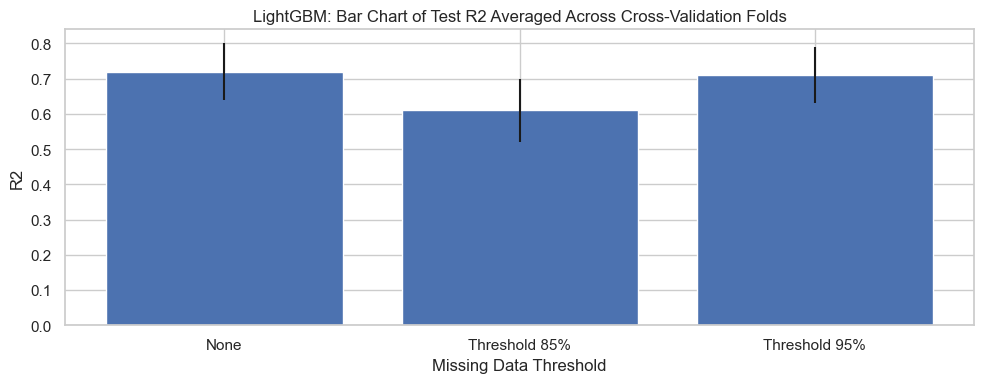

In [ ]:
mean_data = mean_summary.astype(float)
std_data = std_summary.astype(float)

for metric in mean_data.columns:
    plt.figure(figsize=(10, 4))
    d_full = mean_data[metric]
    d = mean_data[metric].values
    e = std_data[metric].values
    plt.bar(d_full.index, d, yerr = e)
    plt.title("LightGBM: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

In [23]:
mean_corr = mean_summary.corr()
mean_corr

,MAPE,MAE,MSE,RMSE,R2
MAPE,1.000000,0.939586,0.948369,0.948832,-0.872763
MAE,0.939586,1.000000,0.782503,0.783413,-0.652939
MSE,0.948369,0.782503,1.000000,0.999999,-0.982526
RMSE,0.948832,0.783413,0.999999,1.000000,-0.982253
R2,-0.872763,-0.652939,-0.982526,-0.982253,1.000000


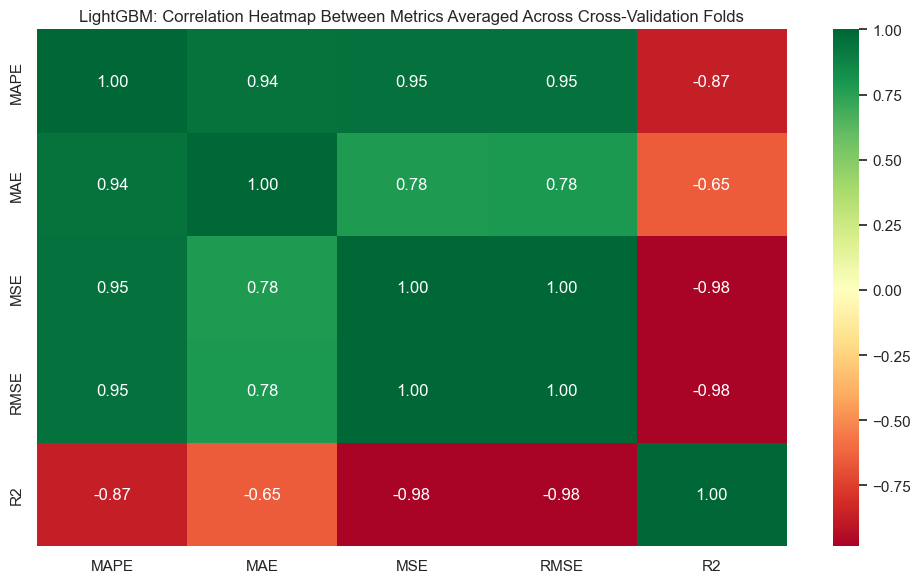

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("LightGBM: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds")
plt.tight_layout()
plt.show()

### extras